# **1. Import thư viện**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc)



# **2. Chuẩn bị dữ liệu**

In [2]:
# Đọc file dữ liệu đã làm sạch
df = pd.read_csv('ECommerce_Dataset_cleaned_model.csv')

In [3]:
df.shape

(5630, 15)

In [4]:
df.head()

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,DaySinceLastOrder,CashbackAmount,DevicePerTenure
0,1,3,6,3,3,Laptop & Accessory,2,Single,9,1,11,1,5,160,0.75
1,1,1,8,3,4,Mobile Phone,3,Single,7,1,15,0,0,121,4.00
2,1,1,30,2,4,Mobile Phone,3,Single,6,1,14,0,3,120,4.00
3,1,3,15,2,4,Laptop & Accessory,5,Single,8,0,23,0,3,134,4.00
4,1,1,12,3,3,Mobile Phone,5,Single,3,0,11,1,3,130,3.00


In [5]:
# Xác định biến đầu vào và mục tiêu
target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

In [6]:
# Xác định cột định lượng (numeric) và định tính (categorical)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [7]:
print(f"\nCategorical: {cat_cols}")
print(f"Numerical: {num_cols}")


Categorical: ['PreferedOrderCat', 'MaritalStatus']
Numerical: ['CityTier', 'WarehouseToHome', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'OrderAmountHikeFromlastYear', 'CouponUsed', 'DaySinceLastOrder', 'CashbackAmount', 'DevicePerTenure']


In [8]:
# Chia dữ liệu: 80% Train - 20% Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [9]:
print(f"Train set: {X_train.shape} | Test set: {X_test.shape}")

Train set: (4504, 14) | Test set: (1126, 14)


# **3. Tạo Pipeline (Tiền xử lý + Mô hình)**

In [10]:
#ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ]
)

In [11]:
#Model Logistic Regression
model_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))
])

# **4. Cross validation (10-fold)**

In [12]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(model_lr, X_train, y_train, cv=skf, method='predict')
y_proba_cv = cross_val_predict(model_lr, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

roc_auc_cv = roc_auc_score(y_train, y_proba_cv)
print(f"CV ROC-AUC: {roc_auc_cv:.4f}")

CV ROC-AUC: 0.8942


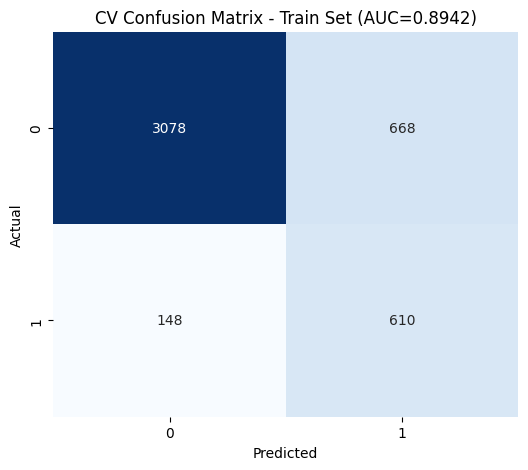

In [13]:
#Confusion Matrix
plt.figure(figsize=(6, 5))
cm_cv = confusion_matrix(y_train, y_pred_cv)
sns.heatmap(cm_cv, annot=True, fmt='d', cmap='Blues',cbar=False)
plt.title(f'CV Confusion Matrix - Train Set (AUC={roc_auc_cv:.4f})')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **5. Huấn luyện & dự đoán**

In [14]:
#train model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CityTier',
                                                   'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'DevicePerTenure']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [15]:
# Dự đoán trên tập Test
y_pred = model_lr.predict(X_test)
y_prob = model_lr.predict_proba(X_test)[:, 1]

# **6. Đánh giá mô hình**


In [16]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.83      0.89       936
           1       0.49      0.80      0.61       190

    accuracy                           0.83      1126
   macro avg       0.72      0.82      0.75      1126
weighted avg       0.88      0.83      0.84      1126



In [17]:
auc_score = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Score: {auc_score:.4f}")

ROC-AUC Score: 0.8857


**Nhận xét:**
* Mô hình Logistic Regression đạt **Accuracy 83%** và **ROC-AUC Score 0.8857**. Chỉ số ROC-AUC gần **0.89** cho thấy mô hình có khả năng phân tách tốt giữa hai nhóm khách hàng, khá tốt để so sánh.

  *   Lớp 0 (Non-churn): Đạt Precision rất cao (0.95), nghĩa là khi mô hình dự báo khách hàng ở lại, độ tin cậy lên tới 95%. Tuy nhiên, Recall đạt 0.83, thấp hơn Precision, cho thấy mô hình chấp nhận hy sinh một phần độ chính xác của lớp này để tập trung nhận diện lớp Churn.
  * Lớp 1 (Churn): Với **Recall** đạt **0.80**: Mô hình đã phát hiện thành công **80%** số lượng khách hàng thực sự rời bỏ.
  Tuy nhiên, **Precision** còn thấp (**0.49**), tức chỉ có khoảng **50%** các cảnh báo rời bỏ là chính xác.Do sử dụng class_weight='balanced'làm cho mô hình trở nên nhạy cảm hơn, dẫn đến việc báo động giả  tăng lên.
* **Kết luận** : Kết quả này khẳng định tính khả thi của bài toán,
nhưng đặt ra yêu cầu cần áp dụng các thuật toán phi tuyến tính phức tạp hơn để cải thiện Precision, nhằm giảm thiểu rủi ro nhận diện sai mà vẫn duy trì được Recall cao.




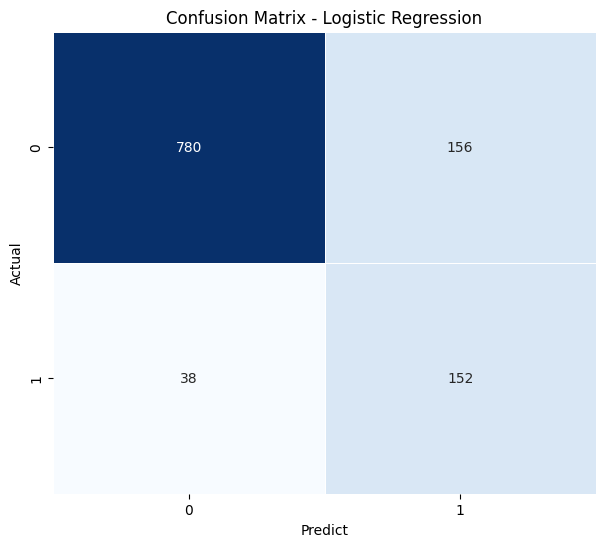

In [18]:
#Trực quan hóa kết quả
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=False, linewidths=0.5)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()



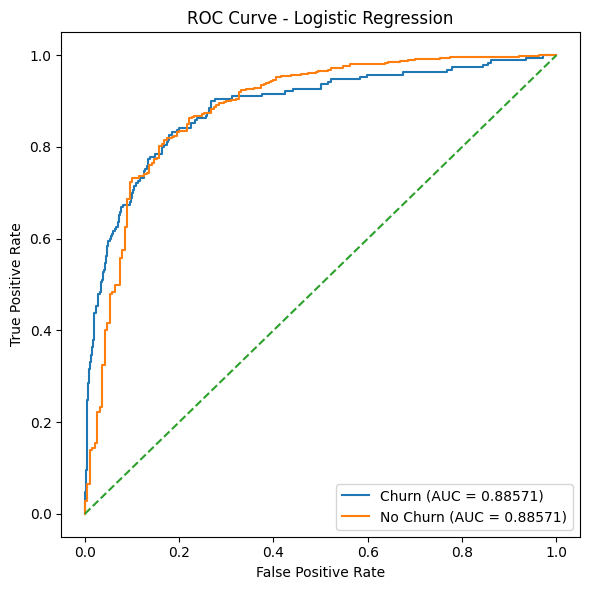

In [19]:
# 2. ROC Curve
y_proba_full = model_lr.predict_proba(X_test)
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba_full[:, 1])
auc_1 = auc(fpr_1, tpr_1)
fpr_0, tpr_0, _ = roc_curve(1 - y_test, y_proba_full[:, 0])
auc_0 = auc(fpr_0, tpr_0)
# Vẽ biểu đồ
plt.figure(figsize=(6, 6))
plt.plot(fpr_1, tpr_1, label=f'Churn (AUC = {auc_1:.5f})')
plt.plot(fpr_0, tpr_0, label=f'No Churn (AUC = {auc_0:.5f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét**


1. Confusion Matrix:
Về khả năng phát hiện tạm ổn, mô hình bắt đúng **152/190** khách hàng rời bỏ.
Độ chính xác tệ, tỷ lệ báo động giả quá cao. Tổng cộng mô hình đưa ra cảnh báo cho **308** khách hàng (152 đúng + 156 sai). Trong đó, có tới **156** khách hàng trung thành bị nhận diện nhầm là sẽ rời bỏ.
2. ROC Curve: **AUC = 0.89** là mức khá tốt, cho thấy mô hình đã học được quy luật để phân biệt rõ ràng giữa khách hàng rời bỏ và khách hàng trung thành.Đường ROC vòng lên cao và nằm xa đường chéo ngẫu nhiên, chứng tỏ mô hình hoạt động ổn định, đủ độ tin cậy để làm mốc so sánh (Baseline) cho các thuật toán phức tạp hơn.




In [20]:
filename = 'model_logistic_regression.joblib'
joblib.dump(model_lr, filename)
print(f"\nĐã lưu mô hình vào file: {filename}")


Đã lưu mô hình vào file: model_logistic_regression.joblib
